In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy.stats import zscore

In [4]:
train_data=pd.read_csv('data/train.csv')
test_data=pd.read_csv('data/test.csv')

train_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

## I. Gérer valeurs manquantes ##

In [6]:
missing_values_train=train_data.isna().sum()
print(missing_values_train.sort_values(ascending=False).head(10))

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageQual        81
GarageFinish      81
GarageType        81
dtype: int64


In [7]:
# on va drop les colonnes qui contiennent le plus de valeurs manquantes
# je rajoute ici la variable 'Utilities' car toutes les valeurs sont identiques, elle n'a donc aucun intérêt. De + elle présente des valeurs manquantes dans le test.
train_data.drop(['Alley', 'PoolQC', 'Fence', 'MiscFeature', 'MasVnrType', 'Utilities'], axis=1, inplace=True)

In [8]:
# on regarde si les valeurs manquantes de 'FireplaceQu' correspondent aux valeurs nulles de 'Fireplaces'
values_FireplaceQu=train_data['FireplaceQu'].value_counts(dropna=False)
values_Fireplaces=train_data['Fireplaces'].value_counts()

print(values_FireplaceQu)
print(values_Fireplaces)

FireplaceQu
NaN    690
Gd     380
TA     313
Fa      33
Ex      24
Po      20
Name: count, dtype: int64
Fireplaces
0    690
1    650
2    115
3      5
Name: count, dtype: int64


In [9]:
# c'est le cas,les donées manquantes de 'FireplaceQu' signifient qu'il n'y a pas de cheminée, on va donc remplacer NaN par None
train_data.loc[:, 'FireplaceQu'] = train_data['FireplaceQu'].fillna('None')

train_data['FireplaceQu'].value_counts(dropna=False)

FireplaceQu
None    690
Gd      380
TA      313
Fa       33
Ex       24
Po       20
Name: count, dtype: int64

<Axes: xlabel='LotFrontage', ylabel='Count'>

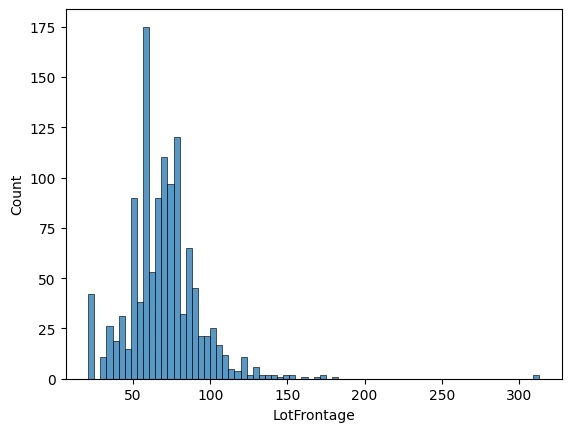

In [10]:
sns.histplot(train_data['LotFrontage'])

In [11]:
train_data['LotFrontage'].value_counts(dropna=False)

LotFrontage
NaN      259
60.0     143
70.0      70
80.0      69
50.0      57
        ... 
182.0      1
160.0      1
152.0      1
153.0      1
46.0       1
Name: count, Length: 111, dtype: int64

In [12]:
# On implémente les valeurs manquantes de 'LotFrontage' par la médiane
train_data['LotFrontage']=train_data['LotFrontage'].fillna(train_data['LotFrontage'].median())

In [13]:
train_data['GarageType'].value_counts(dropna=False)

GarageType
Attchd     870
Detchd     387
BuiltIn     88
NaN         81
Basment     19
CarPort      9
2Types       6
Name: count, dtype: int64

Pour les colonnes 'GarageType, 'GarageQual', 'GarageCond' et 'GarageFinish', les valeurs manquantes signifient qu'il n'y a pas de garage. On les remplace donc par None.

In [14]:
train_data.loc[:, ['GarageType', 'GarageQual', 'GarageCond', 'GarageFinish']] = train_data[['GarageType', 'GarageQual', 'GarageCond','GarageFinish']].fillna('None')

In [15]:
train_data['GarageType'].value_counts(dropna=False)

GarageType
Attchd     870
Detchd     387
BuiltIn     88
None        81
Basment     19
CarPort      9
2Types       6
Name: count, dtype: int64

En vérifiant toutes les variables concernant les garages, on se rend compte qu'il y a bien 81 maisons sans garages. On va donc créer une variable 'HasGarage'.

In [16]:
# création de la variable 'HasGarage'
train_data['HasGarage']=train_data['GarageYrBlt'].notna().astype(int)
train_data['HasGarage'].value_counts(dropna=False)

HasGarage
1    1379
0      81
Name: count, dtype: int64

<Axes: xlabel='HasGarage', ylabel='SalePrice'>

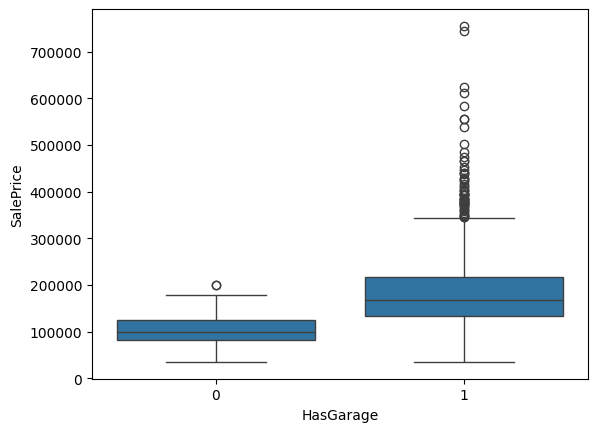

In [17]:
# on regarde l'influence d'avoior un garage dans le prix de vente
sns.boxplot(train_data, x='HasGarage', y='SalePrice')

<Axes: xlabel='YearBuilt', ylabel='GarageYrBlt'>

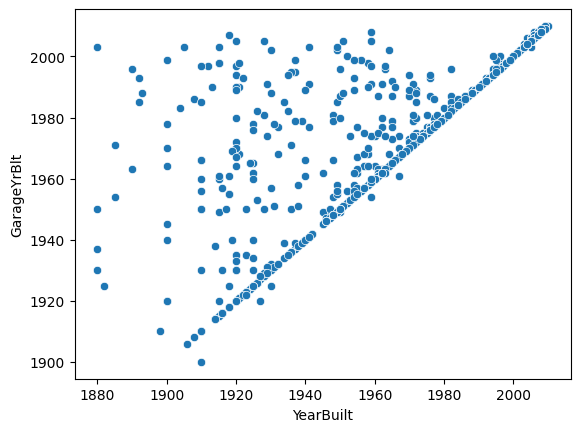

In [18]:
sns.scatterplot(train_data, x='YearBuilt', y='GarageYrBlt')

In [19]:
correlation=train_data[['GarageYrBlt', 'YearBuilt']].corr()
print(correlation)


             GarageYrBlt  YearBuilt
GarageYrBlt     1.000000   0.825667
YearBuilt       0.825667   1.000000


La corrélation entre 'GarageYrBlt' et 'YearBuilt' est grande (0.82) mais pas assez pour supprimer 'GarageYrBlt'. Il faut donc trouver un moyen pour imputer les valeurs manquantes

In [20]:
# je regarde ce qu'il se passe si j'impute les variables manquantes avec l'année de construction de la maison

train_data['GarageYrBlt'] = train_data['GarageYrBlt'].fillna(train_data['YearBuilt'])

correlation=train_data[['GarageYrBlt', 'YearBuilt']].corr()
print(correlation)

             GarageYrBlt  YearBuilt
GarageYrBlt     1.000000   0.845141
YearBuilt       0.845141   1.000000


La corrélation entre les 2 variables n'a pas tant augmenté, je vais donc rester sur cette méthode.

In [21]:
train_data['TotalBsmtSF'].value_counts(dropna=False)

TotalBsmtSF
0       37
864     35
672     17
912     15
1040    14
        ..
1525     1
482      1
1542     1
839      1
1286     1
Name: count, Length: 721, dtype: int64

In [22]:
train_data[['Id','TotalBsmtSF','BsmtFinType2', 'BsmtExposure']].loc[(train_data['TotalBsmtSF']!=0) & (train_data['BsmtFinType2'].isna()),:] 

,Id,TotalBsmtSF,BsmtFinType2,BsmtExposure
332,333,3206,NaN,No


In [23]:
train_data[['Id','TotalBsmtSF','BsmtFinType2', 'BsmtExposure']].loc[(train_data['TotalBsmtSF']!=0) & (train_data['BsmtExposure'].isna()),:] 

,Id,TotalBsmtSF,BsmtFinType2,BsmtExposure
948,949,936,Unf,NaN


J'ai trouvé les 2 lignes qui posaient soucis car dans certaines variables elles avaient un basement et dans d'autres non. Je vais donc les supprimer


In [24]:
# suppression des 2 lignes :
train_data.drop(train_data[train_data['Id'].isin([949, 333])].index, inplace=True)

In [25]:
train_data

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,LotConfig,LandSlope,...,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,HasGarage
0,1,60,RL,65.0,8450,Pave,Reg,Lvl,Inside,Gtl,...,0,0,0,0,2,2008,WD,Normal,208500,1
1,2,20,RL,80.0,9600,Pave,Reg,Lvl,FR2,Gtl,...,0,0,0,0,5,2007,WD,Normal,181500,1
2,3,60,RL,68.0,11250,Pave,IR1,Lvl,Inside,Gtl,...,0,0,0,0,9,2008,WD,Normal,223500,1
3,4,70,RL,60.0,9550,Pave,IR1,Lvl,Corner,Gtl,...,0,0,0,0,2,2006,WD,Abnorml,140000,1
4,5,60,RL,84.0,14260,Pave,IR1,Lvl,FR2,Gtl,...,0,0,0,0,12,2008,WD,Normal,250000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,Reg,Lvl,Inside,Gtl,...,0,0,0,0,8,2007,WD,Normal,175000,1
1456,1457,20,RL,85.0,13175,Pave,Reg,Lvl,Inside,Gtl,...,0,0,0,0,2,2010,WD,Normal,210000,1
1457,1458,70,RL,66.0,9042,Pave,Reg,Lvl,Inside,Gtl,...,0,0,0,2500,5,2010,WD,Normal,266500,1
1458,1459,20,RL,68.0,9717,Pave,Reg,Lvl,Inside,Gtl,...,0,0,0,0,4,2010,WD,Normal,142125,1


In [26]:
# je crée une variable binaire pour la présence de cave
train_data['HasBasement'] = train_data['BsmtQual'].notnull().astype(int)

# je remplace toutes les valeurs manquantes des variables catégorielles qui concernent le 'Basement' par la valeur 'No Basement'
basement_columns = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']
train_data[basement_columns] = train_data[basement_columns].fillna('No Basement')

<Axes: xlabel='BsmtFinType1', ylabel='SalePrice'>

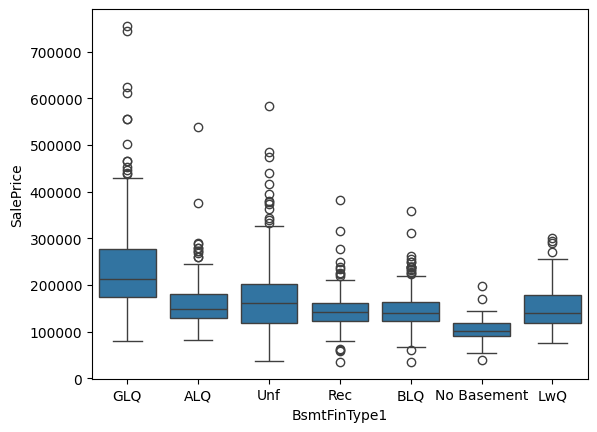

In [27]:
# oe veut checker si la valeur 'No Basement' a une influence sur le prix de vente et il semblerait que oui donc on ne va surtout pas supprimer ces lignes là
sns.boxplot(data=train_data, x='BsmtFinType1', y='SalePrice')

In [28]:
missing_values=train_data.isna().sum().sort_values(ascending=False)
print(missing_values.head())

MasVnrArea    8
Electrical    1
MSZoning      0
MSSubClass    0
Id            0
dtype: int64


In [29]:
# on va implémenter la valeur manquante par la valeur la plus fréquente dans la variable :
mode_value=train_data['Electrical'].mode()[0]
train_data['Electrical']=train_data['Electrical'].fillna(mode_value) 
# pas besoin de le faire sur le test_data car aucune valeur manquante pour cette variable

<Axes: xlabel='MasVnrArea', ylabel='Count'>

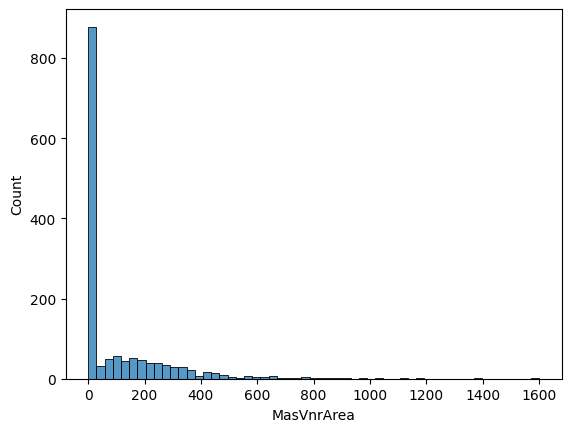

In [30]:
sns.histplot(train_data, x='MasVnrArea')

<Axes: xlabel='MasVnrArea', ylabel='SalePrice'>

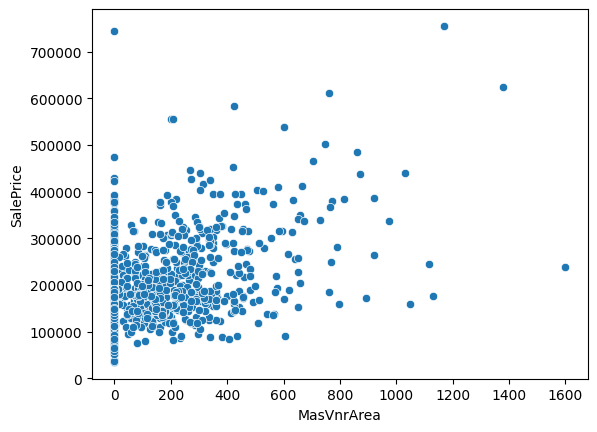

In [31]:
sns.scatterplot(data=train_data, x='MasVnrArea', y='SalePrice') 

In [32]:
train_data['MasVnrArea']=train_data['MasVnrArea'].fillna(train_data['MasVnrArea'].median())
# la médiane est en fait 0 mais cela n'est sans doute pas un problème

In [33]:
# iqr=np.quantile(train_data.MasVnrArea, q=[0.25, 0.75])
# limite_basse=iqr[0]-1.5*(iqr[1]-iqr[0])
# limite_haute=iqr[1]+1.5*(iqr[1]-iqr[0])
# print(limite_basse, limite_haute)

# on vérifie combien de lignes la méthode des quantiles supprimerait 
# train_data[(train_data['MasVnrArea']>limite_haute)].value_counts().sum()

In [34]:
# on vérifie combien de lignes la méthode des quantiles supprimerait 
# train_data[(train_data['MasVnrArea']>limite_haute)].value_counts().sum()

La méthode des quantiles supprimerait 98 lignes ce qui représente un grand nombre pour le faible échantillons que nous avons. Nous allons donc chercher un autre moyen de gérer les valeurs extrêmes.

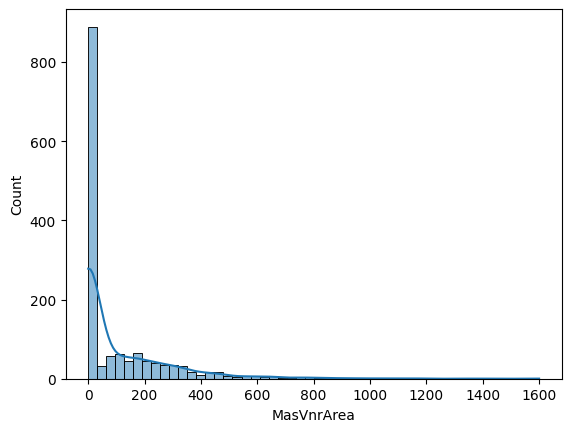

In [35]:
sns.histplot(train_data['MasVnrArea'], bins=50, kde=True)
plt.show()

Le problème de cette variable 'MasVnrArea' est qu'il y a une quantité importante de 0 ce qui pose soucis pour son traitement. Nous allons d'abord créer une variable binaire qui indique la présence ou non de de revêtement en maçonnerie. Ensuite on va sans doute faire une transformation logarithmique pour garder cette variable dans le traitement des données.

In [36]:
# création de la variable binaire 'HasMasonry'
train_data['HasMasonry'] = (train_data['MasVnrArea']>0).astype(int)
train_data['HasMasonry'].value_counts(dropna=False)

HasMasonry
0    869
1    589
Name: count, dtype: int64

<Axes: xlabel='HasMasonry', ylabel='SalePrice'>

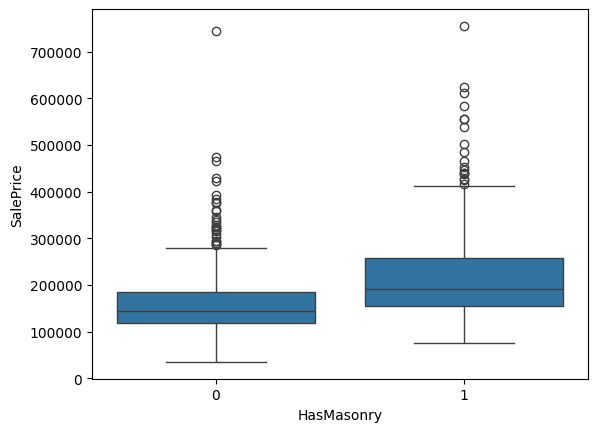

In [37]:
# on vérifie si la variable 'HasMasonry' a une influence sur le prix de vente
sns.boxplot(data=train_data, x='HasMasonry', y='SalePrice')

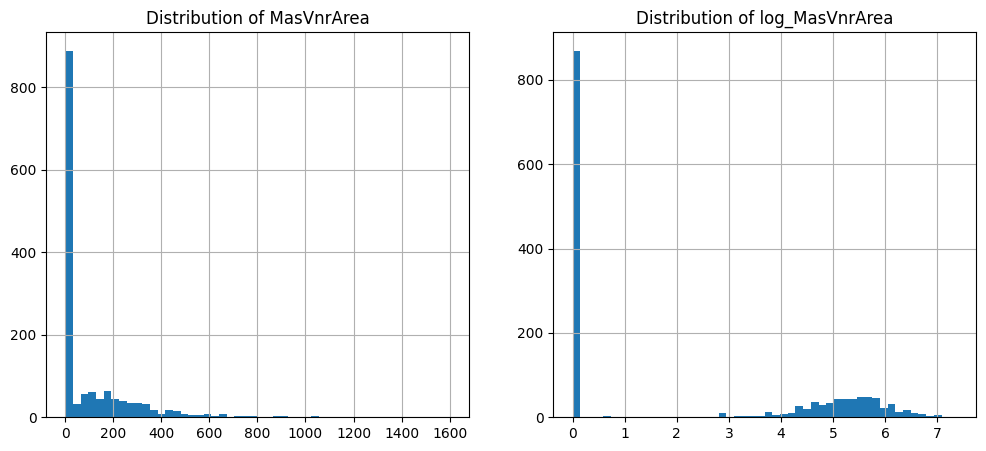

In [38]:
# transformation logarithmique de la variable 'MasVnrArea'

# on utilise np.log1p car il y a des valeurs égales à 0
train_data['Log_MasVnrArea'] = np.log1p(train_data['MasVnrArea']) 

# on compare ensuite les 2 distributions
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
train_data['MasVnrArea'].hist(bins=50)
plt.title('Distribution of MasVnrArea')

plt.subplot(1,2,2)
train_data['Log_MasVnrArea'].hist(bins=50)
plt.title('Distribution of log_MasVnrArea')

plt.show()

In [39]:
# on choisit de garder la variable 'log_MasVnrArea' car elle semble mieux distribuée
train_data.drop('MasVnrArea', axis=1, inplace=True)
# nous n'avons plus de donées manquantes dans notre jeu de données 'train_data'

## II. Valeurs manquantes dans le jeu de données TEST ##

In [40]:
# Cette fonction recense tous les changements que nous avons fait sur le jeu de données et permet de les appliquer sur le jeu de données test
# excepté évidemment quelques cas particulier où nous avons retiré des lignes

def preprocess_data(df):
    df.loc[:, 'FireplaceQu'] = df['FireplaceQu'].fillna('None')
    df.drop(['Alley', 'PoolQC', 'Fence', 'MiscFeature', 'MasVnrType', 'Utilities'], axis=1, inplace=True)
    df.loc[:, ['GarageType', 'GarageQual', 'GarageCond', 'GarageFinish']] = df[['GarageType', 'GarageQual', 'GarageCond', 'GarageFinish']].fillna('None')
    df['LotFrontage']=df['LotFrontage'].fillna(df['LotFrontage'].median())
    df['HasGarage']=df['GarageYrBlt'].notna().astype(int)
    df['GarageYrBlt'] = df['GarageYrBlt'].fillna(df['YearBuilt'])
    df['HasBasement'] = df['BsmtQual'].notnull().astype(int)
    basement_columns = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']
    df[basement_columns] = df[basement_columns].fillna('No Basement')
    df['MasVnrArea']=df['MasVnrArea'].fillna(df['MasVnrArea'].median())
    df['HasMasonry'] = (df['MasVnrArea']>0).astype(int)
    df['Log_MasVnrArea'] = np.log1p(df['MasVnrArea']) 
    df.drop('MasVnrArea', axis=1, inplace=True)
    return df

In [41]:
preprocess_data(test_data)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,LotConfig,LandSlope,...,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,HasGarage,HasBasement,HasMasonry,Log_MasVnrArea
0,1461,20,RH,80.0,11622,Pave,Reg,Lvl,Inside,Gtl,...,0,0,6,2010,WD,Normal,1,1,0,0.000000
1,1462,20,RL,81.0,14267,Pave,IR1,Lvl,Corner,Gtl,...,0,12500,6,2010,WD,Normal,1,1,1,4.691348
2,1463,60,RL,74.0,13830,Pave,IR1,Lvl,Inside,Gtl,...,0,0,3,2010,WD,Normal,1,1,0,0.000000
3,1464,60,RL,78.0,9978,Pave,IR1,Lvl,Inside,Gtl,...,0,0,6,2010,WD,Normal,1,1,1,3.044522
4,1465,120,RL,43.0,5005,Pave,IR1,HLS,Inside,Gtl,...,0,0,1,2010,WD,Normal,1,1,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,RM,21.0,1936,Pave,Reg,Lvl,Inside,Gtl,...,0,0,6,2006,WD,Normal,0,1,0,0.000000
1455,2916,160,RM,21.0,1894,Pave,Reg,Lvl,Inside,Gtl,...,0,0,4,2006,WD,Abnorml,1,1,0,0.000000
1456,2917,20,RL,160.0,20000,Pave,Reg,Lvl,Inside,Gtl,...,0,0,9,2006,WD,Abnorml,1,1,0,0.000000
1457,2918,85,RL,62.0,10441,Pave,Reg,Lvl,Inside,Gtl,...,0,700,7,2006,WD,Normal,0,1,0,0.000000


Après avoir lancé cette fonction sur le jeu de données test, on va regarder s'il reste des valeurs manquantes et les corriger. 

In [42]:
missing_values=test_data.isna().sum().sort_values(ascending=False)
print(missing_values.head(20))

# il reste quelques valeurs manquantes réparties sur plusieurs colonnes, on va donc sans occuper

MSZoning        4
BsmtHalfBath    2
Functional      2
BsmtFullBath    2
SaleType        1
Exterior1st     1
BsmtUnfSF       1
BsmtFinSF1      1
BsmtFinSF2      1
Exterior2nd     1
KitchenQual     1
GarageCars      1
GarageArea      1
TotalBsmtSF     1
Condition1      0
Neighborhood    0
LandSlope       0
Condition2      0
LandContour     0
LotShape        0
dtype: int64


In [43]:
# on regarde si toutes les valeurs manquantes des variables 'Basement' correspondent à la même ligne
test_data[['BsmtUnfSF','BsmtFinSF1', 'BsmtFinSF2', 'TotalBsmtSF', 'BsmtCond', 'BsmtHalfBath', 'BsmtFullBath']].loc[test_data['BsmtUnfSF'].isna()]

,BsmtUnfSF,BsmtFinSF1,BsmtFinSF2,TotalBsmtSF,BsmtCond,BsmtHalfBath,BsmtFullBath
660,NaN,NaN,NaN,NaN,No Basement,NaN,NaN


In [44]:
# c'est le cas et elles correspondent à une maison sans cave donc on impute toutes les valeurs manquantes par 0
test_data.loc[:,['BsmtUnfSF','BsmtFinSF1', 'BsmtFinSF2', 'TotalBsmtSF', 'BsmtHalfBath', 'BsmtFullBath']] = test_data[['BsmtUnfSF','BsmtFinSF1', 'BsmtFinSF2', 'TotalBsmtSF', 'BsmtHalfBath', 'BsmtFullBath']].fillna(0).astype(int)

In [45]:
# MSZoning est une variable catégorielle avec un grand % des valeurs identiques donc on va imputer les valeurs manquantes par cette valeur
value_mode=test_data['MSZoning'].mode()[0]
test_data['MSZoning']=test_data['MSZoning'].fillna(value_mode)

In [46]:
# de même pour 'Functional'
test_data['Functional']=test_data['Functional'].fillna('Typ')

In [47]:
# on check que les valeurs manquantes de 'GarageArea' et de 'GarageCars' correspondnt bien à la même ligne et s'il y a un garage
test_data[['GarageArea', 'GarageCars', 'HasGarage']].loc[test_data['GarageArea'].isna()]

# il n'y a pas de garage donc on va imputer ces valeurs par 0
test_data[['GarageArea', 'GarageCars']]=test_data[['GarageArea', 'GarageCars']].fillna(0).astype(int)

In [48]:
test_data['SaleType'].value_counts(dropna=False)

SaleType
WD       1258
New       117
COD        44
ConLD      17
CWD         8
Oth         4
ConLI       4
Con         3
ConLw       3
NaN         1
Name: count, dtype: int64

In [49]:
# on check que les valeurs manquantes de 'Exterior1st' et de 'Exterior2nd' correspondnt bien à la meme ligne
test_data[['Exterior1st', 'Exterior2nd']].loc[test_data['Exterior1st'].isna()]

# on impute par la catégorie la plus fréquent 'VinylSd'
test_data[['Exterior1st', 'Exterior2nd']]=test_data[['Exterior1st', 'Exterior2nd']].fillna('VinylSd')

In [50]:
# on impute 'KitchenQual' par la catégorie la plus fréquente
test_data['KitchenQual']=test_data['KitchenQual'].fillna('TA')

# de même pour 'SaleType'
test_data['SaleType']=test_data['SaleType'].fillna('WD')


Maintenant que toutes les valeurs manquantes ont été gérées on va regarder ce qu'il se passe, s'il y a des outliers ou valeurs aberrantes.

## III. Gestion des outliers

In [51]:
# je commence par LotFrontage car j'avais vu quelque chose d'étrange pendant l'exploration
train_data.loc[train_data['LotFrontage']>=200,:]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,LotConfig,LandSlope,...,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,HasGarage,HasBasement,HasMasonry,Log_MasVnrArea
934,935,20,RL,313.0,27650,Pave,IR2,HLS,Inside,Mod,...,0,11,2008,WD,Normal,242000,1,1,0,0.000000
1298,1299,60,RL,313.0,63887,Pave,IR3,Bnk,Corner,Gtl,...,0,1,2008,New,Partial,160000,1,1,1,6.680855


In [52]:
train_data[['Neighborhood', 'LotFrontage', 'YearBuilt', 'TotalBsmtSF', 'GarageArea']].loc[train_data['LotFrontage']>=200,:]

,Neighborhood,LotFrontage,YearBuilt,TotalBsmtSF,GarageArea
934,NAmes,313.0,1960,585,505
1298,Edwards,313.0,2008,6110,1418


Text(0.5, 1.0, 'Distribution of GarageArea')

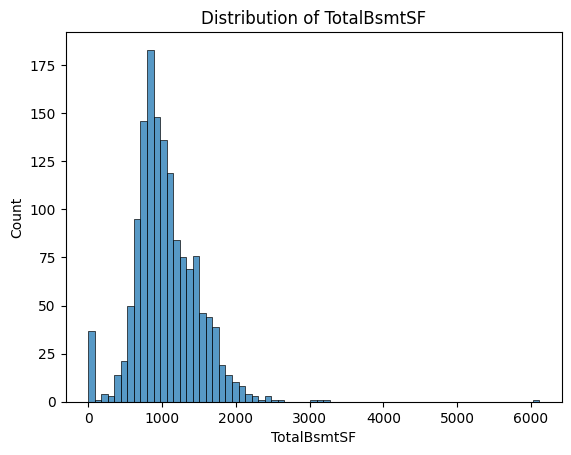

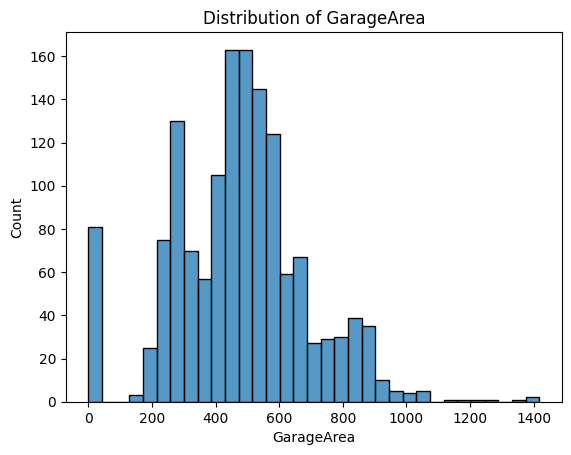

In [53]:
plt.figure()
sns.histplot(train_data['TotalBsmtSF'])
plt.title('Distribution of TotalBsmtSF')

plt.figure()
sns.histplot(train_data['GarageArea'])
plt.title('Distribution of GarageArea')

La ligne (id=1289) semble cohérente car elle possède les plus grandes valeurs de surface sur différentes colonnes. En revanche la ligne (id=934) semble incohérente. On va donc la supprimer dans le doute.

In [54]:
# modification spécifique qui ne peut pas être mis dans la fonction 'preprocess' pour le test
train_data.drop(train_data[train_data['Id']==935].index, inplace=True)

train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1457 entries, 0 to 1459
Data columns (total 78 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Id              1457 non-null   int64  
 1   MSSubClass      1457 non-null   int64  
 2   MSZoning        1457 non-null   object 
 3   LotFrontage     1457 non-null   float64
 4   LotArea         1457 non-null   int64  
 5   Street          1457 non-null   object 
 6   LotShape        1457 non-null   object 
 7   LandContour     1457 non-null   object 
 8   LotConfig       1457 non-null   object 
 9   LandSlope       1457 non-null   object 
 10  Neighborhood    1457 non-null   object 
 11  Condition1      1457 non-null   object 
 12  Condition2      1457 non-null   object 
 13  BldgType        1457 non-null   object 
 14  HouseStyle      1457 non-null   object 
 15  OverallQual     1457 non-null   int64  
 16  OverallCond     1457 non-null   int64  
 17  YearBuilt       1457 non-null   int64 

In [55]:
top5=train_data['LotArea'].nlargest(5)
print(top5)

313    215245
335    164660
249    159000
706    115149
451     70761
Name: LotArea, dtype: int64


In [56]:
train_data.loc[train_data['Id']==314,['LotArea', '1stFlrSF', '2ndFlrSF', 'TotalBsmtSF', 'GarageArea', 'SalePrice']]

,LotArea,1stFlrSF,2ndFlrSF,TotalBsmtSF,GarageArea,SalePrice
313,215245,2036,0,2136,513,375000


<Axes: xlabel='LotArea', ylabel='SalePrice'>

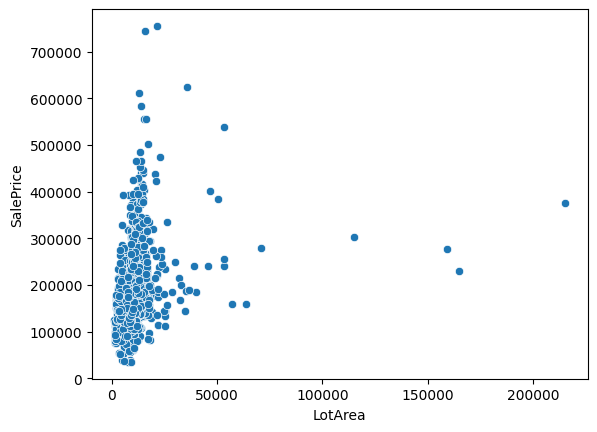

In [57]:
sns.scatterplot(data=train_data, x='LotArea', y='SalePrice')

In [58]:
# la variable 'LowQualFinSF' a une grande majorité de valeurs nulles et son impact sur le prix de vente ne semble pas significatif, on la supprime donc
train_data.drop(['LowQualFinSF'], axis=1, inplace=True)

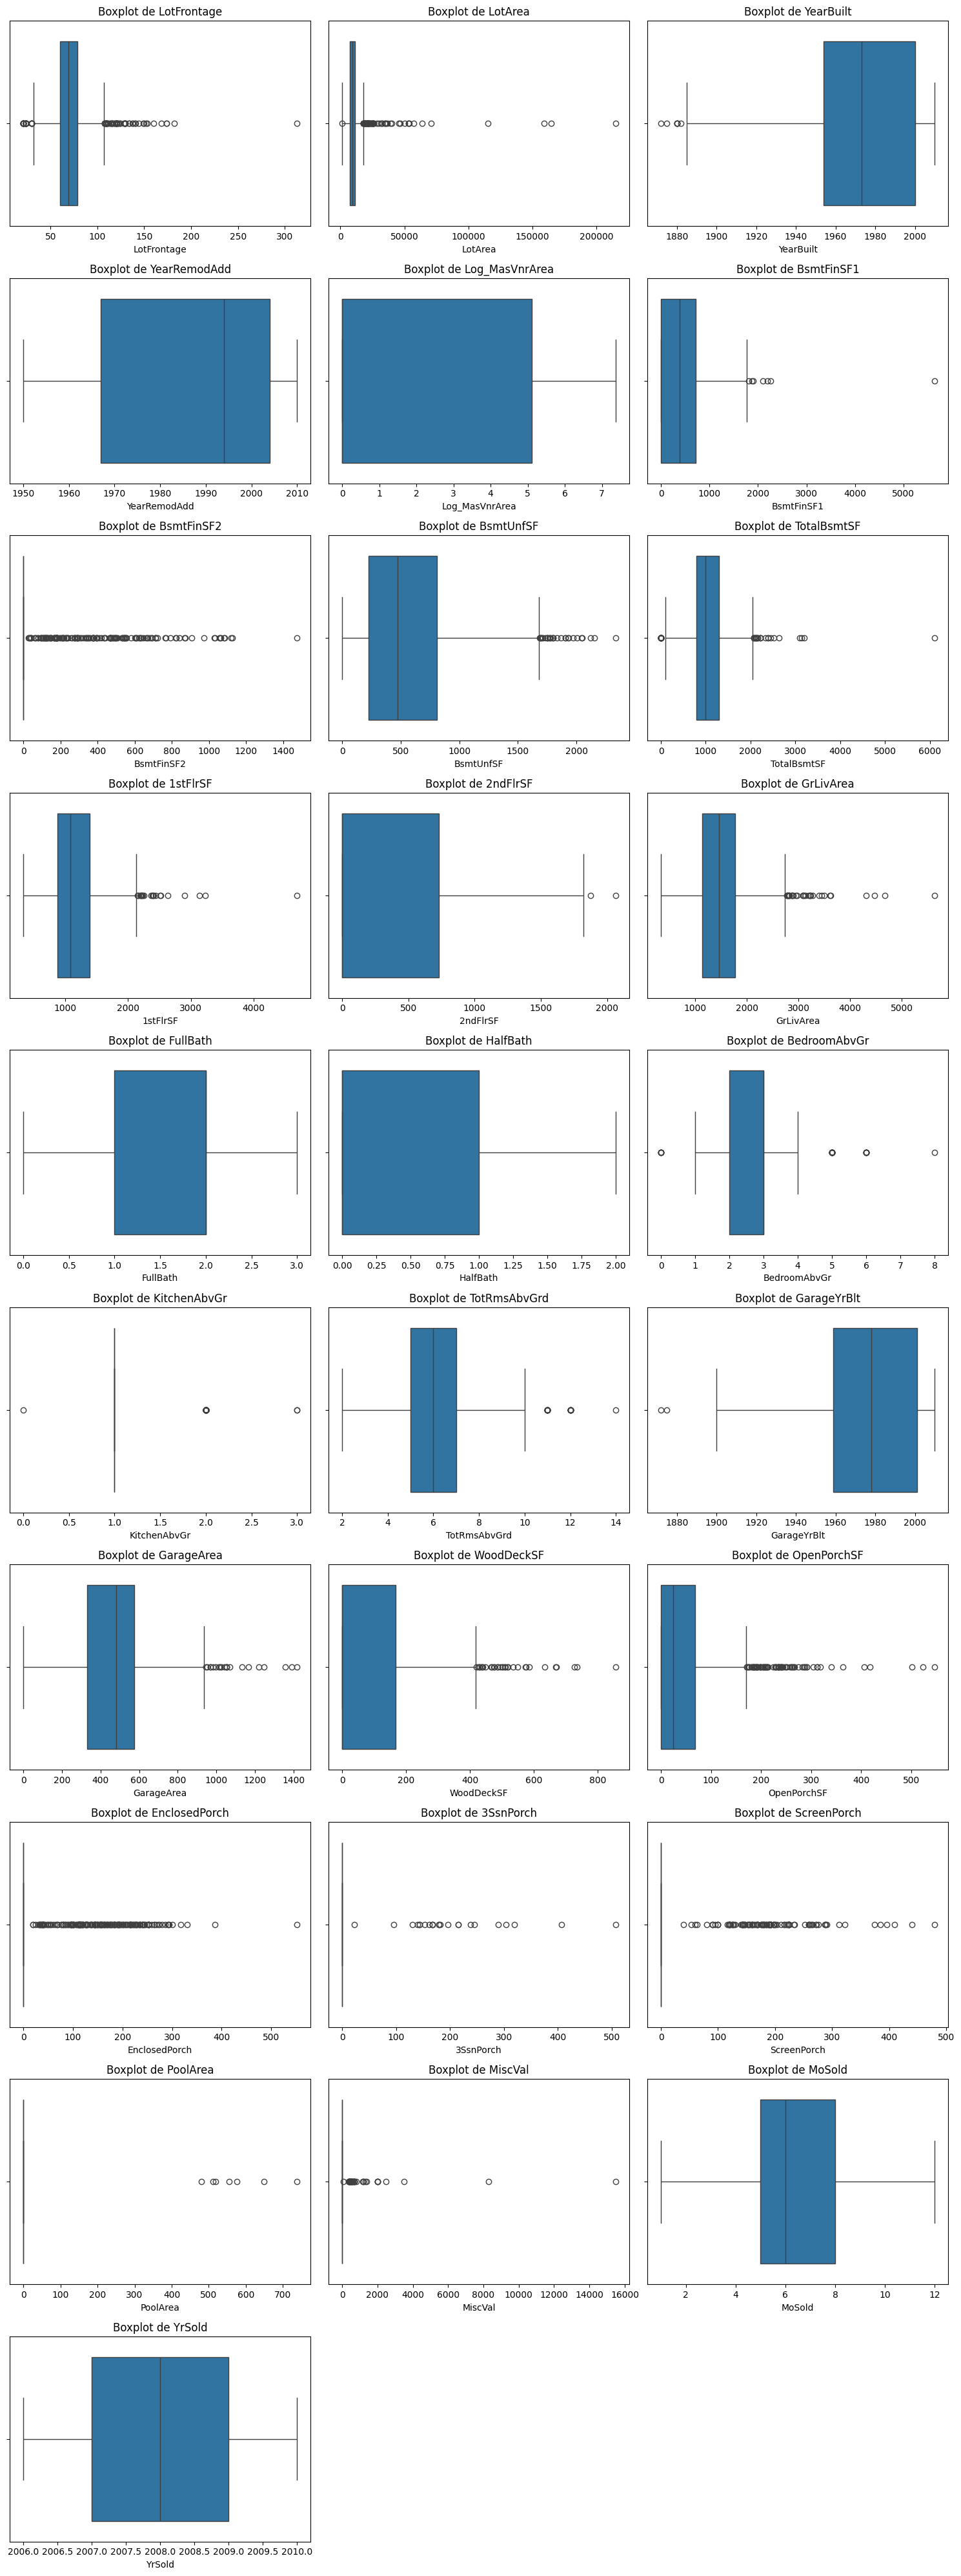

In [59]:
numeric_cols=['LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'Log_MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'GarageYrBlt', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', ]
num_vars = len(numeric_cols)
num_cols = 3  # Nombre de colonnes dans la grille
num_rows = math.ceil(num_vars / num_cols)  # Calcul du nombre de lignes

# Création des subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 4))

# Si une seule ligne, convertir axes en tableau pour éviter les erreurs
axes = axes.flatten() if num_vars > 1 else [axes]

# Tracer chaque boxplot dans la grille
for i, col in enumerate(numeric_cols):
    sns.boxplot(x=train_data[col], ax=axes[i])
    axes[i].set_title(f"Boxplot de {col}")

# Supprimer les axes inutilisés (si le nombre de variables < nombre de cases)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

<Axes: xlabel='BsmtFinSF2', ylabel='SalePrice'>

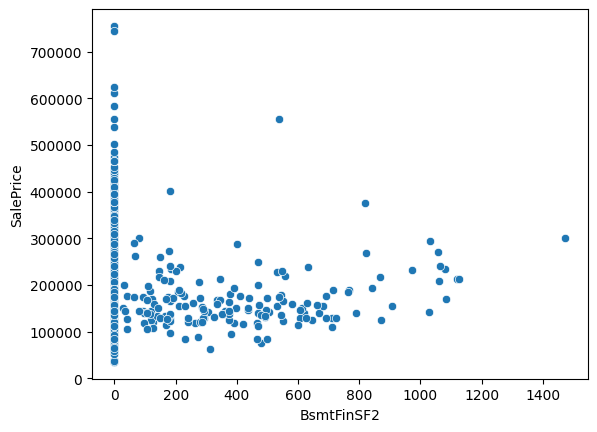

In [60]:
sns.scatterplot(train_data, x='BsmtFinSF2', y='SalePrice')

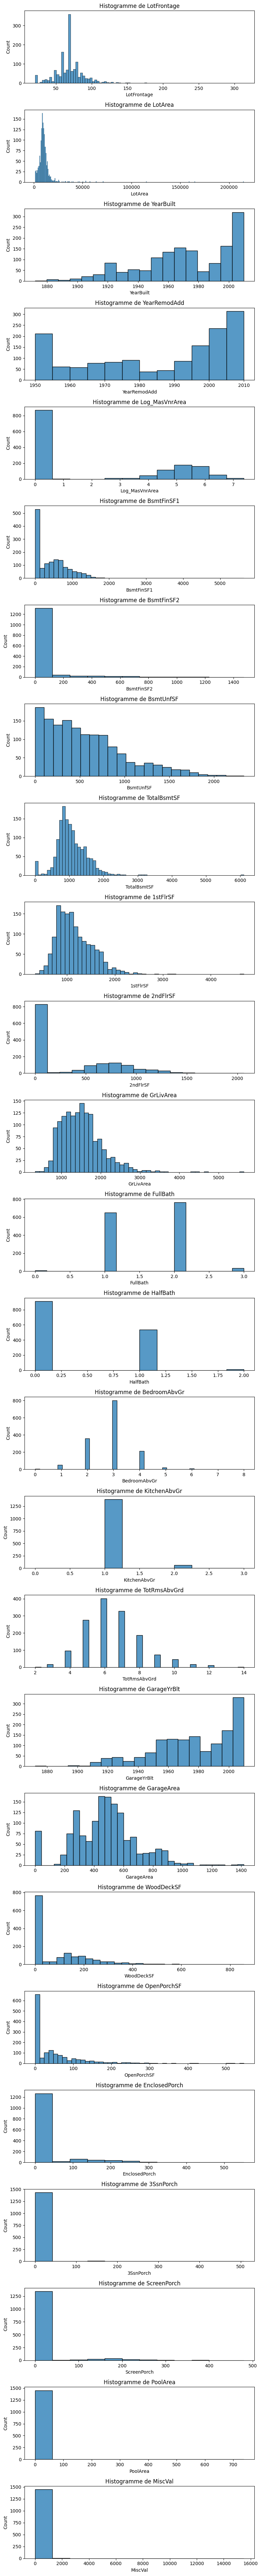

In [61]:
# Récupérer les colonnes numériques continues
numeric_cols=['LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'Log_MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'GarageYrBlt', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal']

# Créer un subplot pour chaque variable
fig, axes = plt.subplots(nrows=len(numeric_cols), figsize=(8, len(numeric_cols) * 3))

for i, col in enumerate(numeric_cols):
    sns.histplot(train_data[col], ax=axes[i])
    axes[i].set_title(f"Histogramme de {col}")

plt.tight_layout()
plt.show()

In [62]:
numeric_cols=['LotFrontage', 'LotArea', 'Log_MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal']

# Appliquer le Z-score et détecter les outliers
z_scores = train_data[numeric_cols].apply(zscore)  # Calculer le Z-score pour chaque colonne
outliers = (np.abs(z_scores) > 3)  # Définir un seuil de |Z| > 3

# Compter le nombre d'outliers par variable
outliers_count = outliers.sum()

# Afficher les résultats
print("Nombre d'outliers par variable :")
print(outliers_count)

# Afficher les observations contenant au moins un outlier
outliers_train_data = train_data[outliers.any(axis=1)]  # Sélectionner les lignes avec au moins un outlier
print(f"\nNombre d'observations avec au moins un outlier : {outliers_train_data.shape[0]}")
print(outliers_train_data)









Nombre d'outliers par variable :
LotFrontage       17
LotArea           13
Log_MasVnrArea     0
BsmtFinSF1         6
BsmtFinSF2        50
BsmtUnfSF         11
TotalBsmtSF        9
1stFlrSF          12
2ndFlrSF           4
GrLivArea         16
FullBath           0
HalfBath          12
BedroomAbvGr      14
KitchenAbvGr      68
TotRmsAbvGrd      12
GarageArea         7
WoodDeckSF        22
OpenPorchSF       27
EnclosedPorch     51
3SsnPorch         23
ScreenPorch       55
PoolArea           7
MiscVal            8
dtype: int64

Nombre d'observations avec au moins un outlier : 326
        Id  MSSubClass MSZoning  LotFrontage  LotArea Street LotShape  \
3        4          70       RL         60.0     9550   Pave      IR1   
5        6          50       RL         85.0    14115   Pave      IR1   
7        8          60       RL         69.0    10382   Pave      IR1   
8        9          50       RM         51.0     6120   Pave      Reg   
9       10         190       RL         50.0     742

In [63]:
# ici sont sélectionnées les variables qui après remplacement par 98 ou 99ème quantiles présentent moins d'outliers à la fin
# pour certaines le nombre d'outliers augmentait, ces variables ont donc été retiré des séléctions "numeric_cols"

numeric_cols_1=['BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'HalfBath', 'TotRmsAbvGrd', 'GarageArea', 'PoolArea']
numeric_cols_2=['LotFrontage', 'GrLivArea', 'WoodDeckSF']

In [64]:
train_data_majorized = train_data.copy()

for col in numeric_cols_1:
    # Calculer le 99ᵉ quantile
    upper_quantile_99 = train_data[col].quantile(0.99)
    
    # Remplacer les valeurs supérieures au 99ᵉ quantile par cette valeur
    train_data_majorized[col] = np.where(train_data[col] > upper_quantile_99, upper_quantile_99, train_data[col])


for col in numeric_cols_2:
    # Calculer le 98ᵉ quantile
    upper_quantile_98 = train_data[col].quantile(0.98)
    
    # Remplacer les valeurs supérieures au 99ᵉ quantile par cette valeur
    train_data_majorized[col] = np.where(train_data[col] > upper_quantile_98, upper_quantile_98, train_data[col])



In [65]:
# Appliquer le Z-score et détecter les outliers
z_scores = train_data_majorized[numeric_cols].apply(zscore)  # Calculer le Z-score pour chaque colonne
outliers = (np.abs(z_scores) > 3)  # Définir un seuil de |Z| > 3

# Compter le nombre d'outliers par variable
outliers_count = outliers.sum()

# Afficher les résultats
print("Nombre d'outliers par variable :")
print(outliers_count)

# Afficher les observations contenant au moins un outlier
outliers_train_data = train_data_majorized[outliers.any(axis=1)]  # Sélectionner les lignes avec au moins un outlier
print(f"\nNombre d'observations avec au moins un outlier : {outliers_train_data.shape[0]}")
print(outliers_train_data)



Nombre d'outliers par variable :
LotFrontage        0
LotArea           13
Log_MasVnrArea     0
BsmtFinSF1         0
BsmtFinSF2        50
BsmtUnfSF          0
TotalBsmtSF        0
1stFlrSF           0
2ndFlrSF           0
GrLivArea          0
FullBath           0
HalfBath           0
BedroomAbvGr      14
KitchenAbvGr      68
TotRmsAbvGrd       0
GarageArea         0
WoodDeckSF         0
OpenPorchSF       27
EnclosedPorch     51
3SsnPorch         23
ScreenPorch       55
PoolArea           0
MiscVal            8
dtype: int64

Nombre d'observations avec au moins un outlier : 270
        Id  MSSubClass MSZoning  LotFrontage  LotArea Street LotShape  \
3        4          70       RL         60.0     9550   Pave      IR1   
5        6          50       RL         85.0    14115   Pave      IR1   
7        8          60       RL         69.0    10382   Pave      IR1   
8        9          50       RM         51.0     6120   Pave      Reg   
9       10         190       RL         50.0     742

## IV. Sélection des variables

In [66]:
# on sélectionne les variables numériques
numerical_cols = train_data_majorized.select_dtypes(include=['int64', 'float64']).columns
numerical_cols = numerical_cols.drop('SalePrice', 'Id')
continuous_cols = [col for col in numerical_cols if train_data_majorized[col].nunique() > 10]

In [67]:
numerical_cols = train_data_majorized.select_dtypes(include=['int64', 'float64'])

# calcul de la corrélation pour les variables continues :
correlation = numerical_cols.corr()
corr_with_price = correlation['SalePrice'].sort_values(ascending=False)

print(corr_with_price.head(10))
print(corr_with_price.tail(10))

SalePrice       1.000000
OverallQual     0.790714
GrLivArea       0.709150
GarageCars      0.639889
TotalBsmtSF     0.638883
GarageArea      0.630318
1stFlrSF        0.622146
FullBath        0.560266
TotRmsAbvGrd    0.537614
YearBuilt       0.522877
Name: SalePrice, dtype: float64
BsmtFinSF2      -0.013629
BsmtHalfBath    -0.016492
MiscVal         -0.021073
Id              -0.021413
YrSold          -0.029702
OverallCond     -0.078139
MSSubClass      -0.083163
EnclosedPorch   -0.128150
KitchenAbvGr    -0.135699
PoolArea              NaN
Name: SalePrice, dtype: float64


In [68]:
# comme il y a beaucoup de variables, on va retirer celles qui semblent faiblement corrélées avec le prix de vente :

abs_corr=corr_with_price.abs()

# je place la limite à 0.3 pour supprimer un maximum de variables et simplifier mes premiers modèles
# on pourra revenir plus tard ici si on veut intégrer plus de variables

threshold=0.3
low_corr_features=abs_corr[abs_corr < threshold].index.tolist()

print("Variables faiblement corrélées avec SalesPrice : ")
print(low_corr_features)


Variables faiblement corrélées avec SalesPrice : 
['LotArea', 'HasGarage', 'BsmtFullBath', 'BsmtUnfSF', 'BedroomAbvGr', 'HasBasement', 'ScreenPorch', '3SsnPorch', 'MoSold', 'BsmtFinSF2', 'BsmtHalfBath', 'MiscVal', 'Id', 'YrSold', 'OverallCond', 'MSSubClass', 'EnclosedPorch', 'KitchenAbvGr']


In [69]:
# on supprimme ces variables qui sont les moins corrélées 

train_data_majorized=train_data_majorized.drop(low_corr_features, axis=1)

In [70]:
train_data_majorized.head()

,MSZoning,LotFrontage,Street,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,...,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,PoolArea,SaleType,SaleCondition,SalePrice,HasMasonry,Log_MasVnrArea
0,RL,65.0,Pave,Reg,Lvl,Inside,Gtl,CollgCr,Norm,Norm,...,TA,Y,0.0,61,0.0,WD,Normal,208500,1,5.283204
1,RL,80.0,Pave,Reg,Lvl,FR2,Gtl,Veenker,Feedr,Norm,...,TA,Y,298.0,0,0.0,WD,Normal,181500,0,0.000000
2,RL,68.0,Pave,IR1,Lvl,Inside,Gtl,CollgCr,Norm,Norm,...,TA,Y,0.0,42,0.0,WD,Normal,223500,1,5.093750
3,RL,60.0,Pave,IR1,Lvl,Corner,Gtl,Crawfor,Norm,Norm,...,TA,Y,0.0,35,0.0,WD,Abnorml,140000,0,0.000000
4,RL,84.0,Pave,IR1,Lvl,FR2,Gtl,NoRidge,Norm,Norm,...,TA,Y,192.0,84,0.0,WD,Normal,250000,1,5.860786


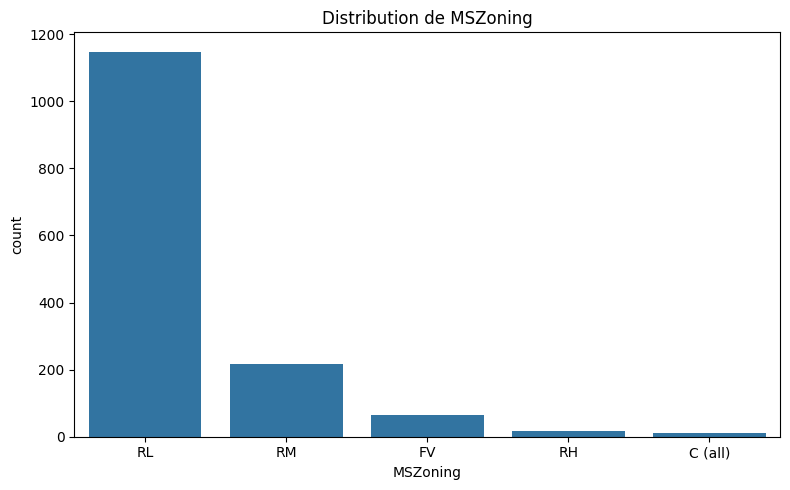

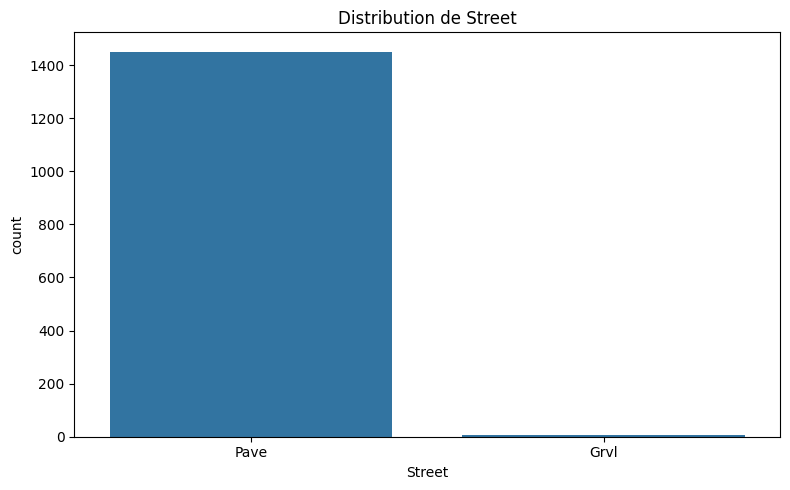

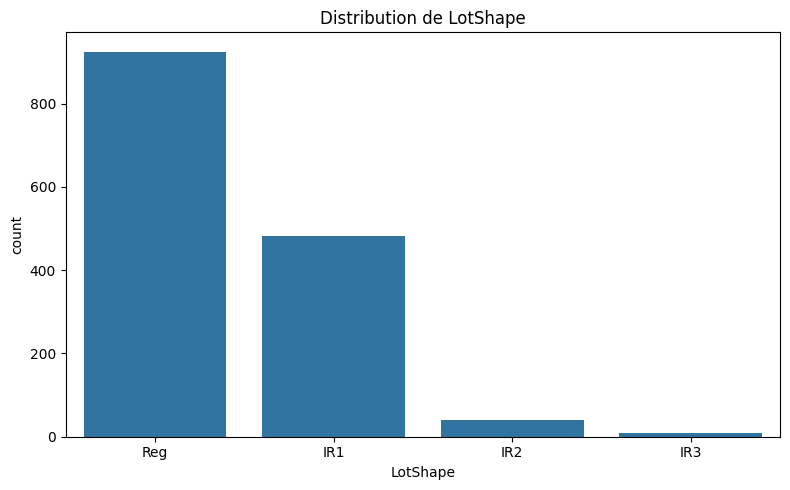

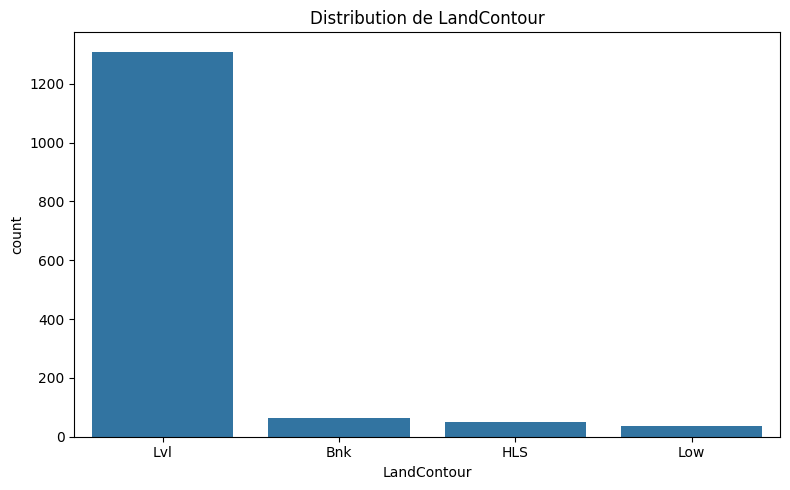

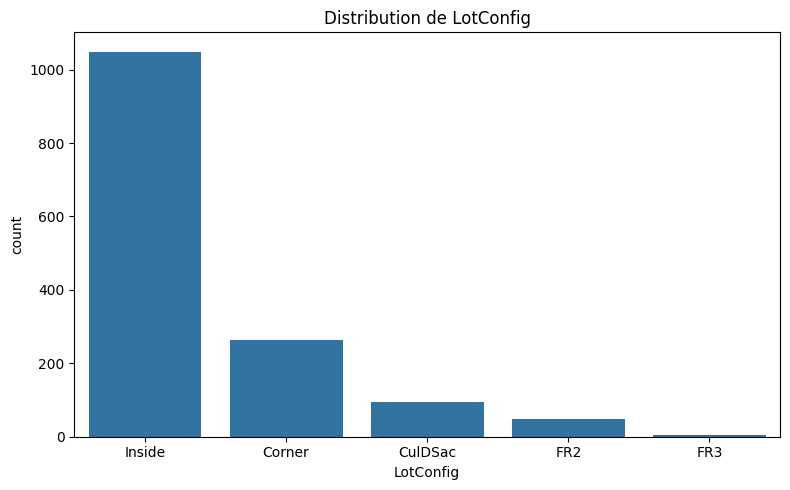

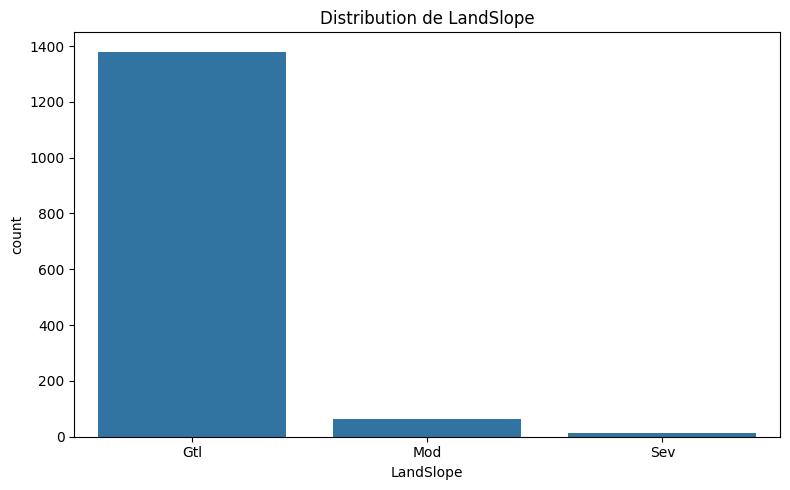

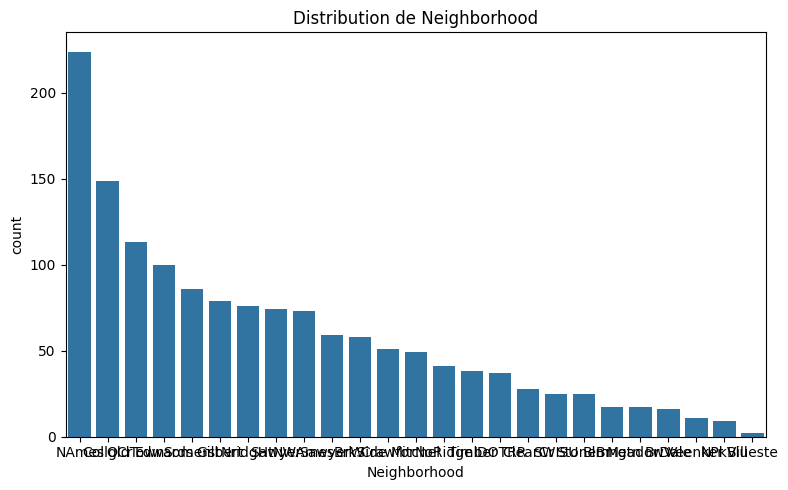

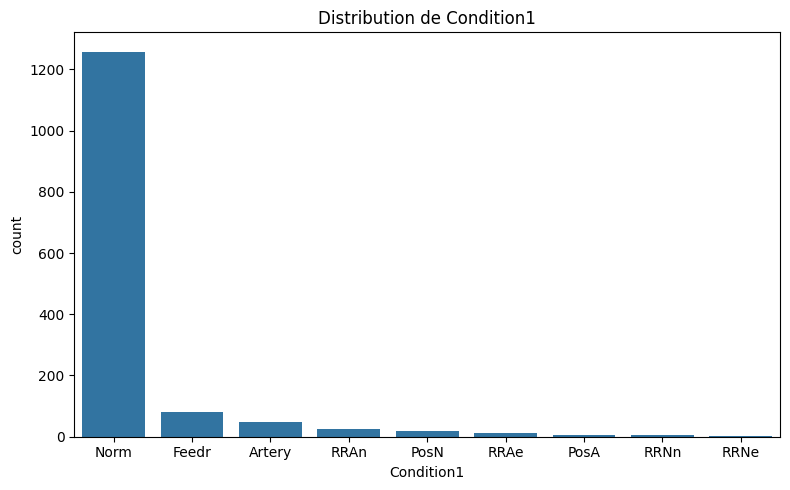

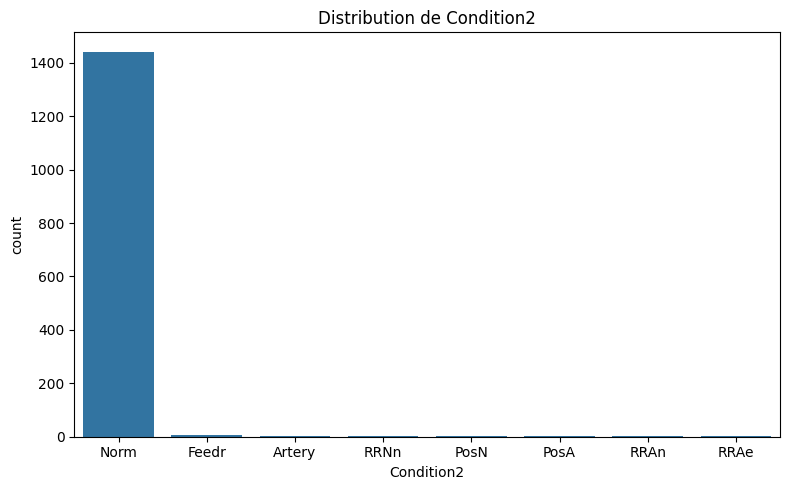

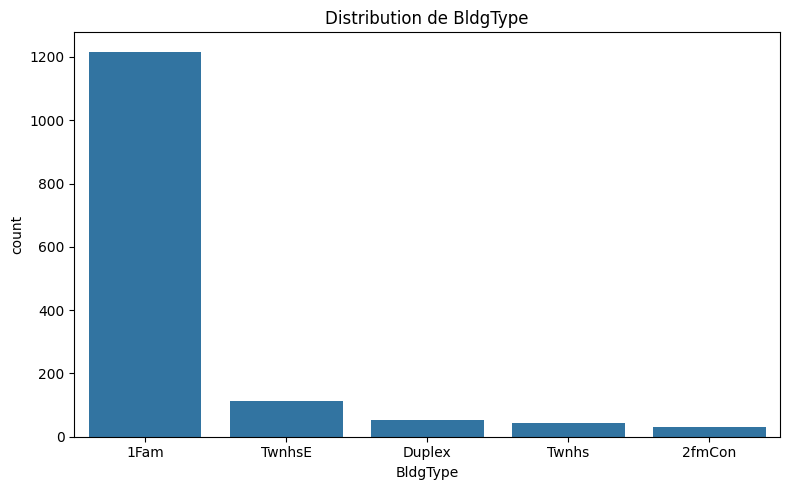

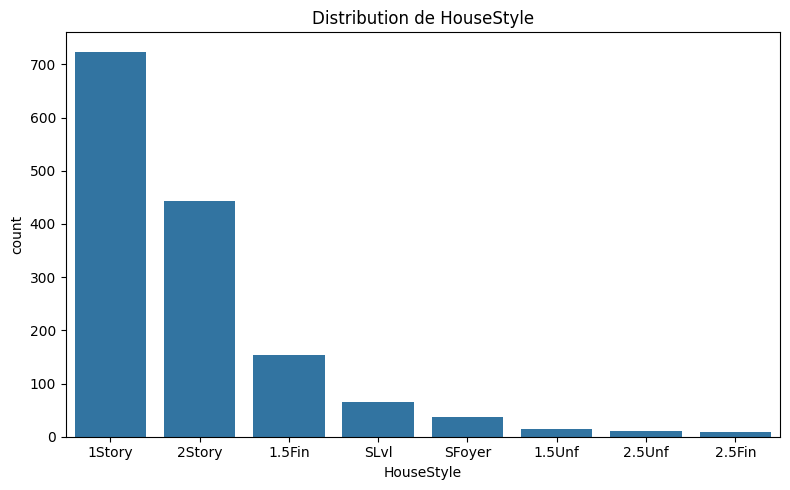

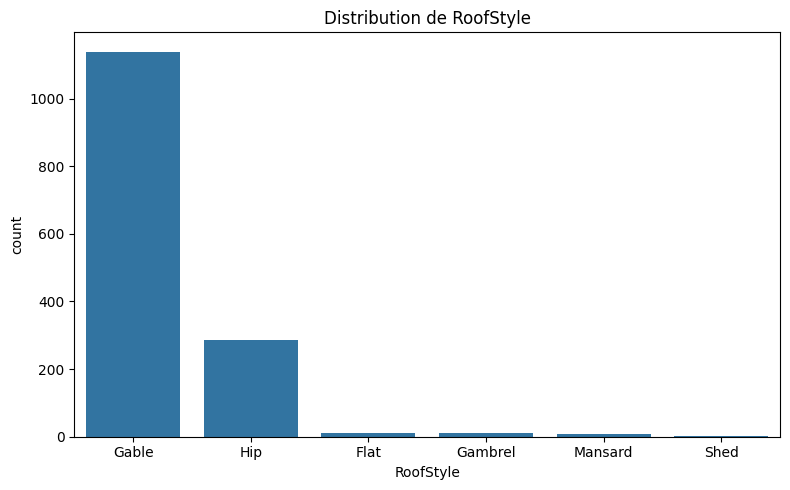

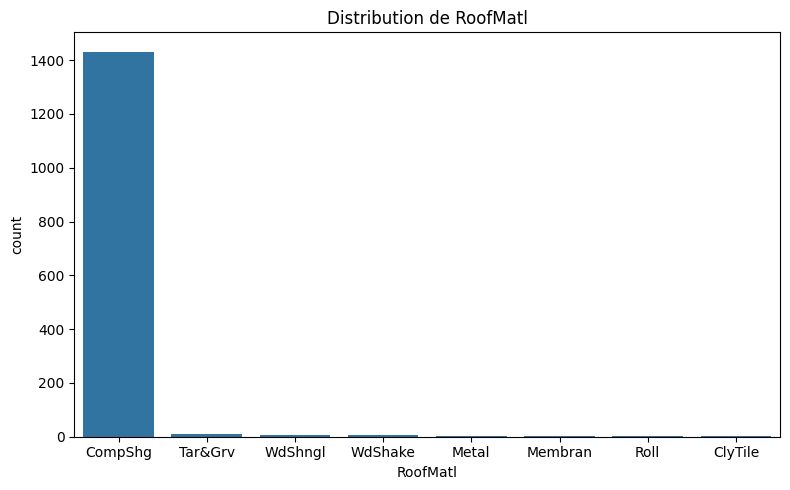

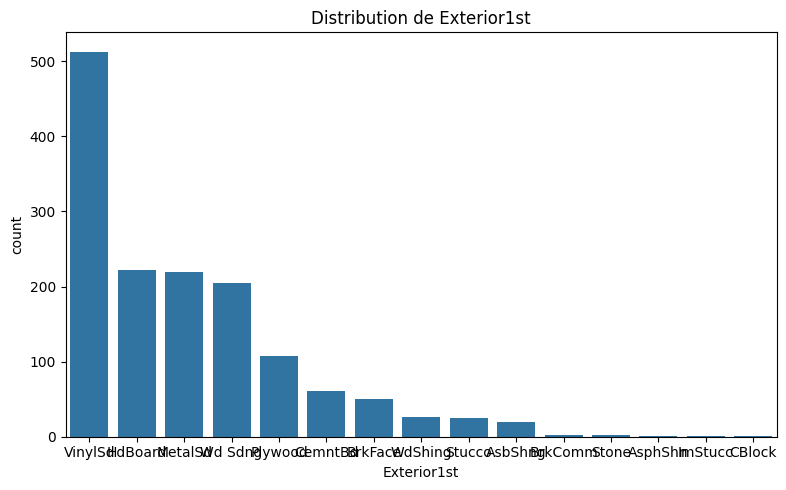

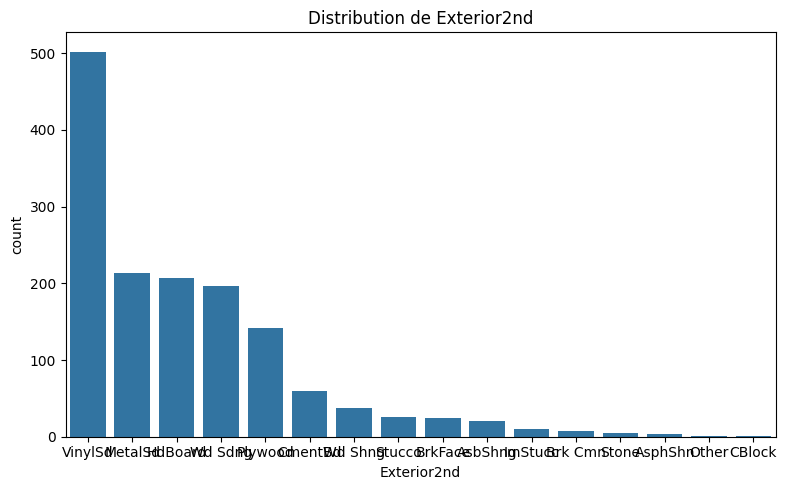

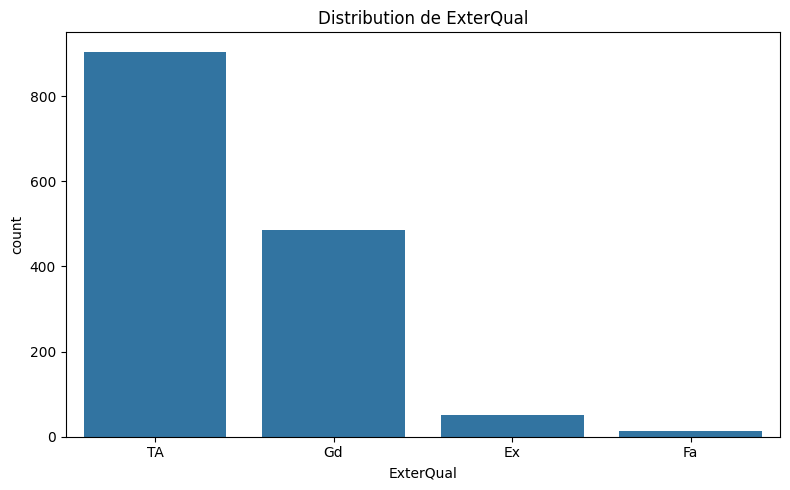

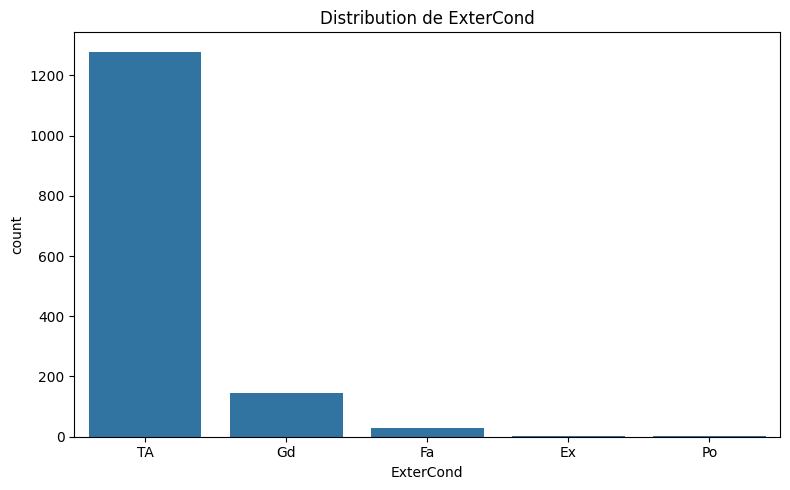

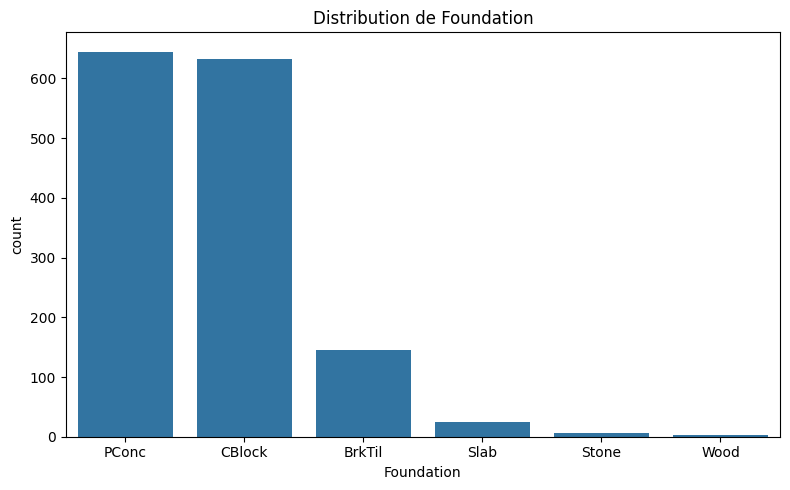

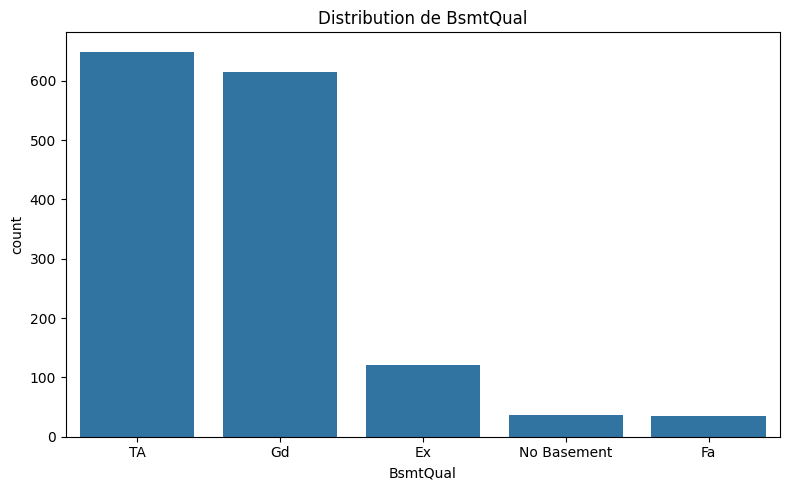

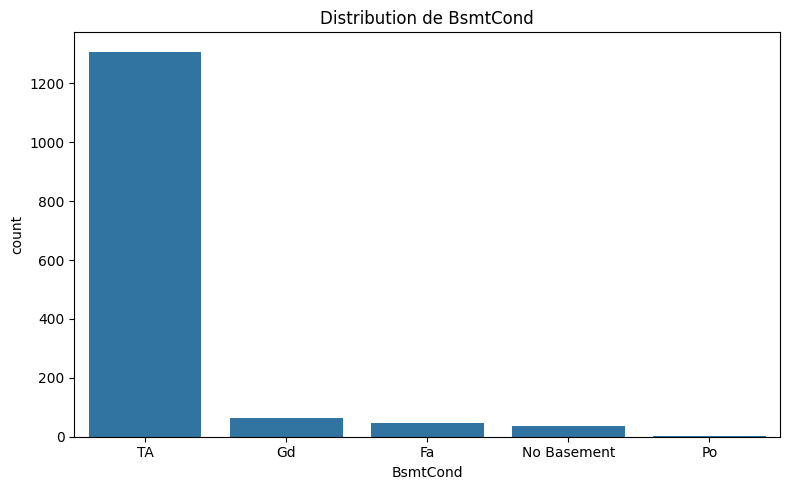

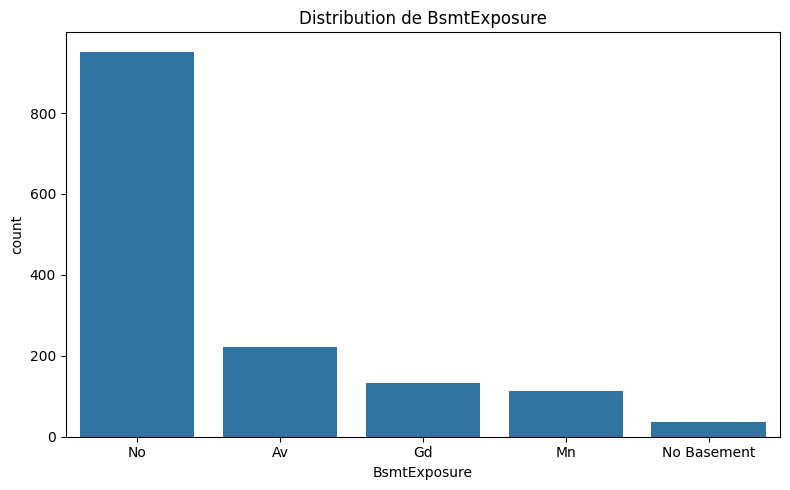

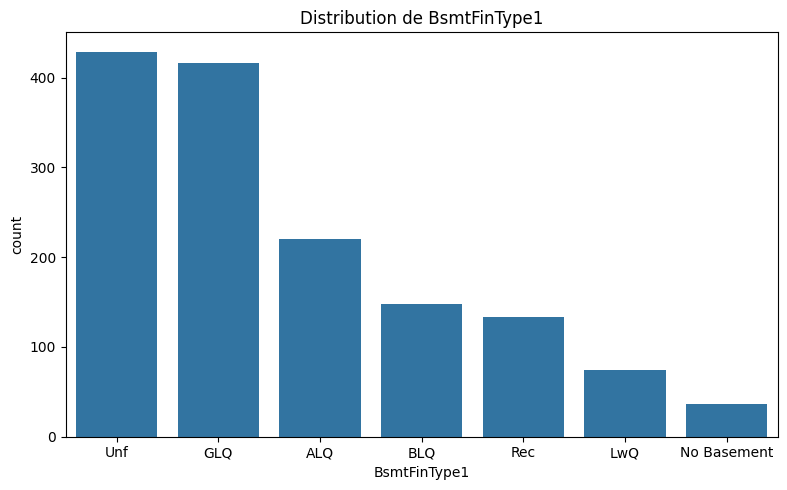

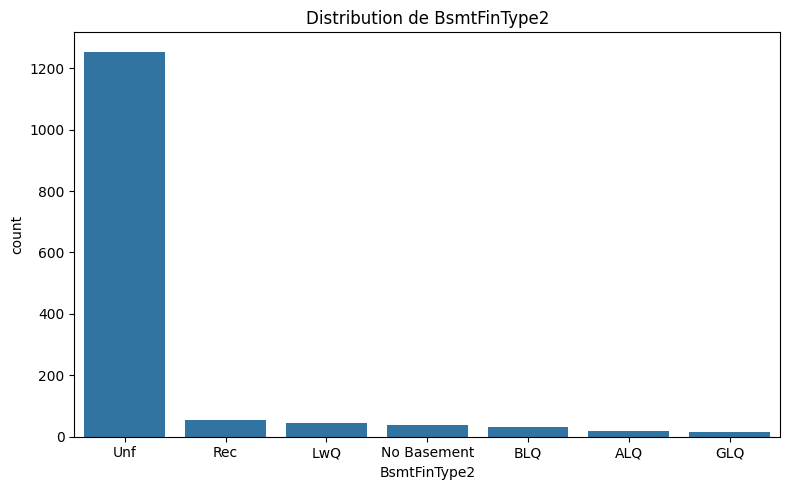

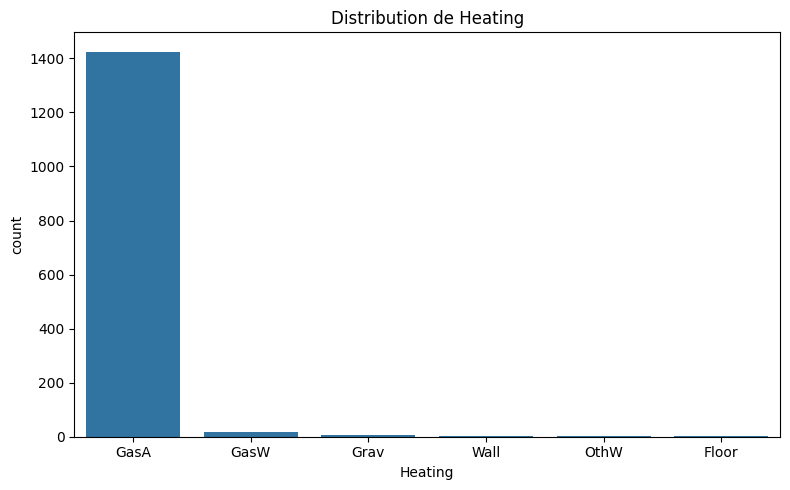

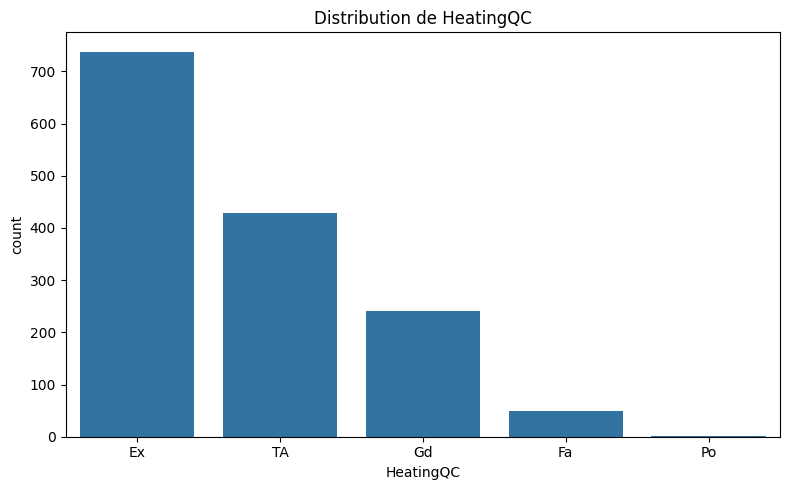

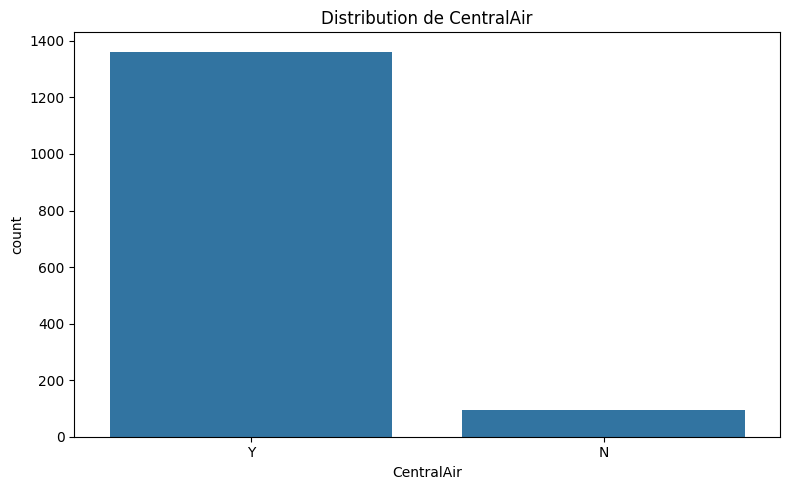

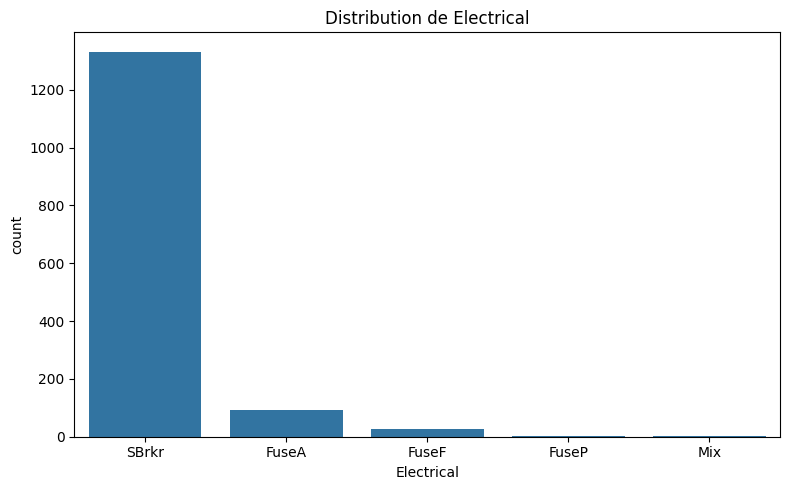

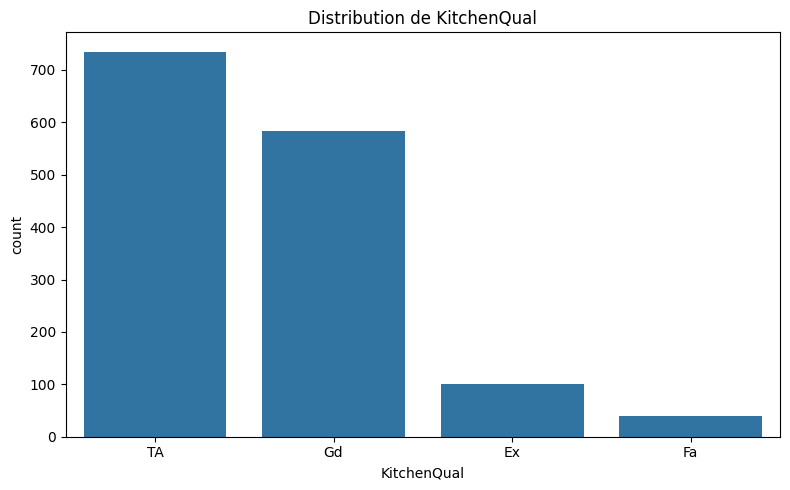

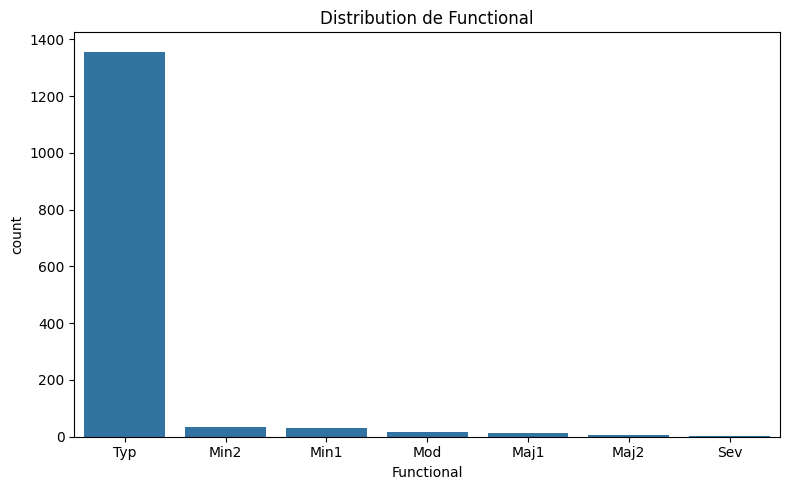

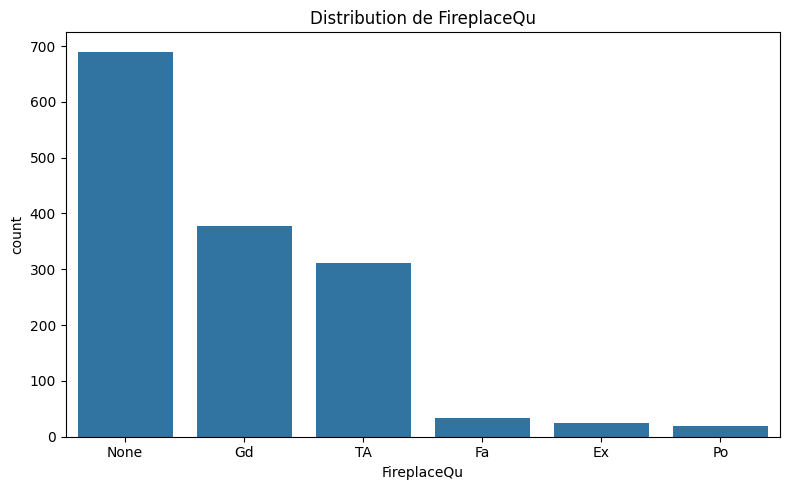

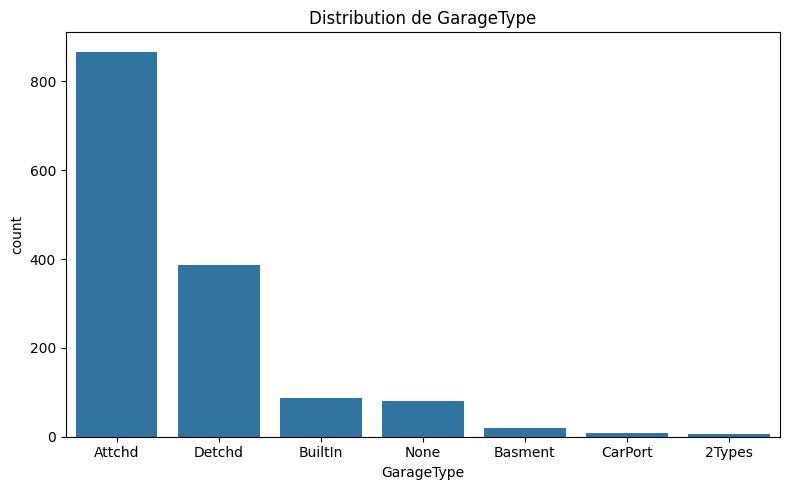

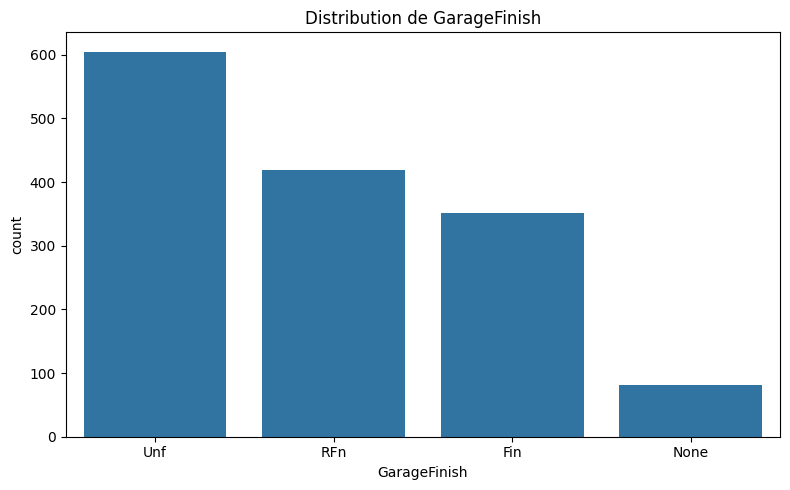

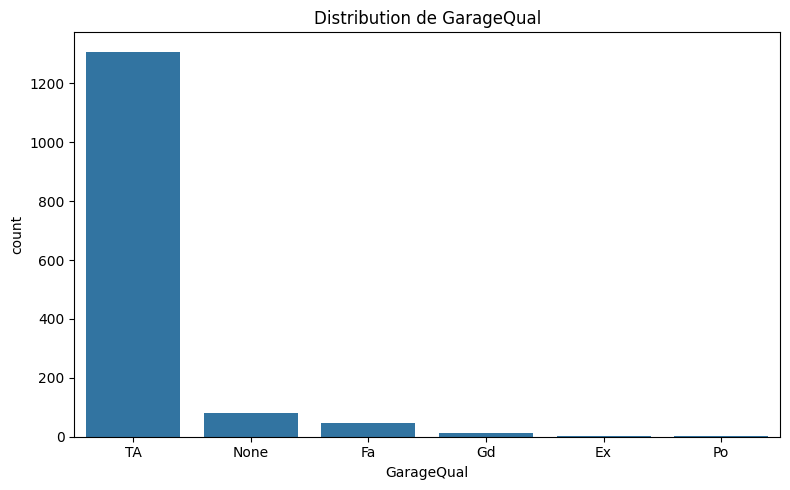

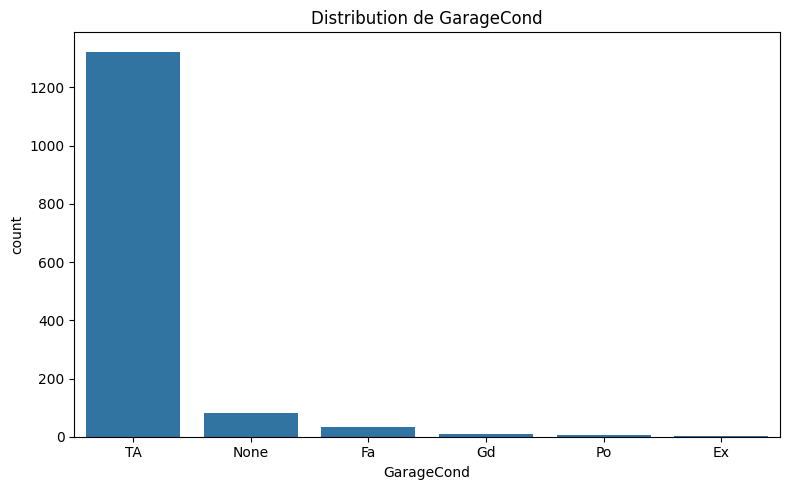

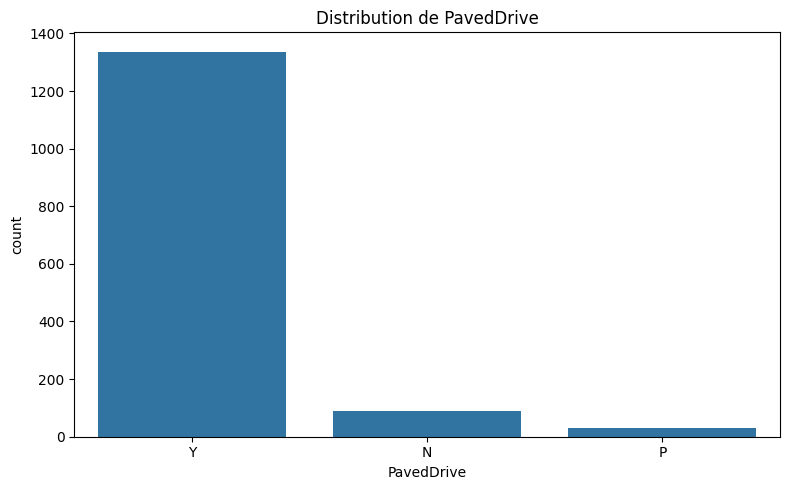

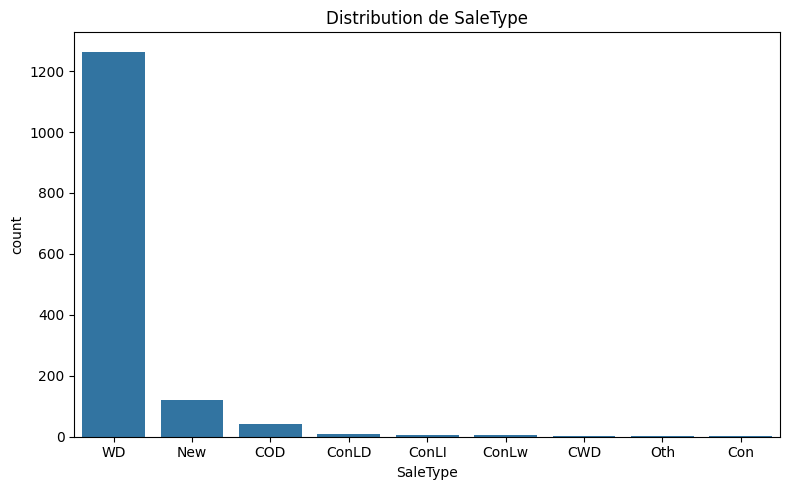

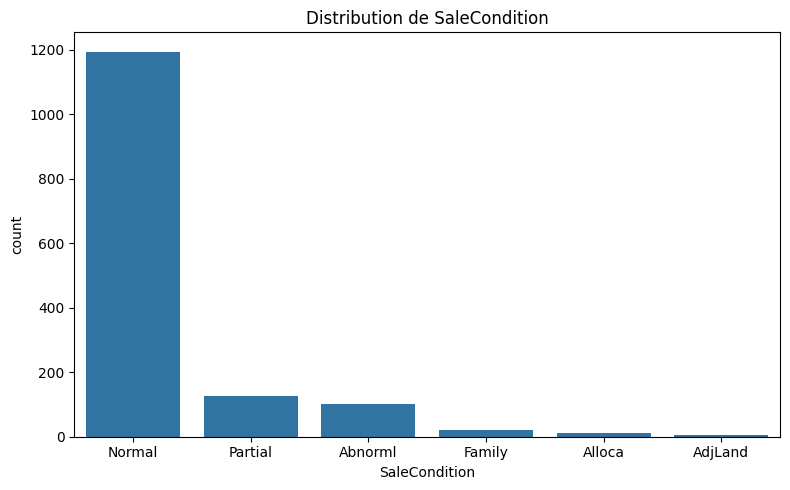

In [71]:
# on s'intéresse maintenant aux variables catégoriques, il va falloir réfléchir à comment les encoder
categorical_cols=train_data_majorized.select_dtypes(include=['object']).columns 

for col in categorical_cols:
    plt.figure(figsize=(8, 5))
    sns.countplot(data=train_data_majorized, x=col, order=train_data_majorized[col].value_counts().index)
    plt.title(f"Distribution de {col}")
    plt.tight_layout()
    plt.show()